# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [ ]:
! pip install Pillow

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [ ]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [ ]:
!ls MNIST

processed  raw


In [ ]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [ ]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

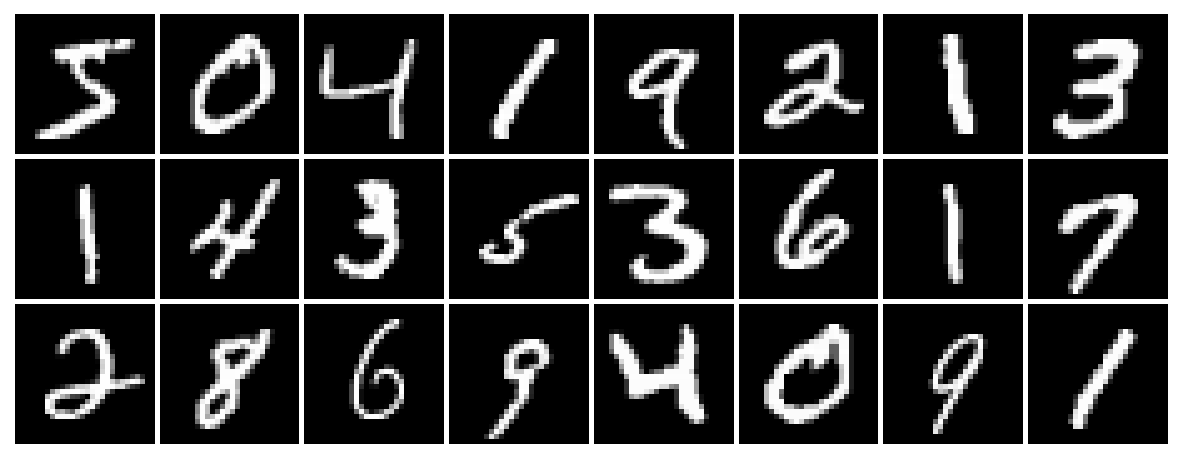

In [ ]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


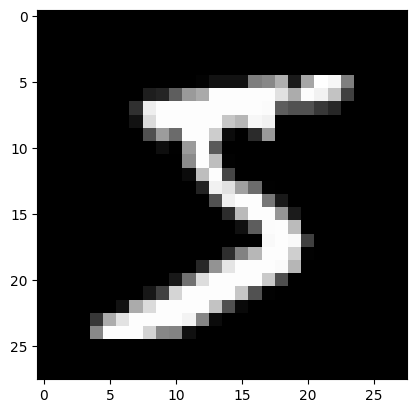

In [ ]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [ ]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [ ]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[-0.2360, -0.0864, -0.2850, -0.0529, -0.0591,  0.1917, -0.2391,  0.4984,
         -0.2981, -0.1016],
        [-0.1939, -0.0595, -0.2019,  0.0261, -0.2206,  0.3666, -0.1819,  0.2705,
         -0.1675, -0.0985],
        [ 0.1159,  0.3541, -0.0099, -0.0661, -0.0833, -0.0228, -0.1174,  0.1390,
         -0.0480, -0.0297],
        [-0.0867,  0.1118, -0.0701,  0.2933, -0.1197,  0.1123, -0.0144,  0.1161,
         -0.2464,  0.1345],
        [ 0.1514,  0.2472, -0.2023,  0.3435, -0.2887,  0.2566,  0.0646,  0.0425,
         -0.2138, -0.0341]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [ ]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [ ]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-uw8ptapy
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-uw8ptapy
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Preparing metadata (setup.py) ... done


In [ ]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3353, grad_fn=<NllLossBackward0>)

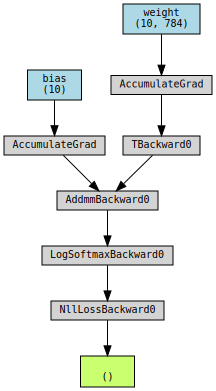

In [ ]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [ ]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [ ]:
print('Final loss:', loss.item())

Final loss: 0.2659463882446289


### Visualizando gráfico de perda durante o treinamento

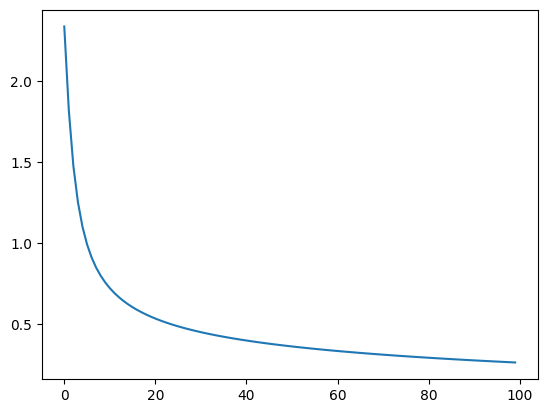

In [ ]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [ ]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.941


### Matriz de confusão com dados de treinamento e teste

In [ ]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,1,3,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,1,1,2,0,3
5,0,2,0,1,0,83,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,110,0,3
8,0,2,2,0,0,1,1,0,81,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


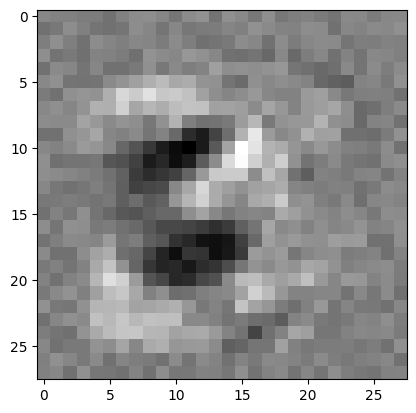

In [ ]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

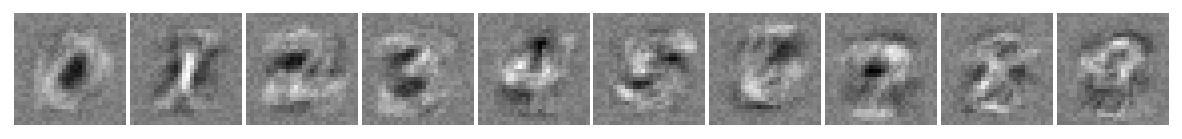

In [ ]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [ ]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print('Epoch[{}/{}], loss: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))



Epoch[1/100], loss: 0.264168
Epoch[2/100], loss: 0.262851
Epoch[3/100], loss: 0.261549
Epoch[4/100], loss: 0.260263
Epoch[5/100], loss: 0.258991
Epoch[6/100], loss: 0.257734
Epoch[7/100], loss: 0.256492
Epoch[8/100], loss: 0.255263
Epoch[9/100], loss: 0.254048
Epoch[10/100], loss: 0.252846
Epoch[11/100], loss: 0.251657
Epoch[12/100], loss: 0.250481
Epoch[13/100], loss: 0.249318
Epoch[14/100], loss: 0.248167
Epoch[15/100], loss: 0.247028
Epoch[16/100], loss: 0.245901
Epoch[17/100], loss: 0.244786
Epoch[18/100], loss: 0.243682
Epoch[19/100], loss: 0.242589
Epoch[20/100], loss: 0.241507
Epoch[21/100], loss: 0.240436
Epoch[22/100], loss: 0.239375
Epoch[23/100], loss: 0.238325
Epoch[24/100], loss: 0.237285
Epoch[25/100], loss: 0.236255
Epoch[26/100], loss: 0.235235
Epoch[27/100], loss: 0.234224
Epoch[28/100], loss: 0.233224
Epoch[29/100], loss: 0.232232
Epoch[30/100], loss: 0.231250
Epoch[31/100], loss: 0.230276
Epoch[32/100], loss: 0.229312
Epoch[33/100], loss: 0.228356
Epoch[34/100], loss

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


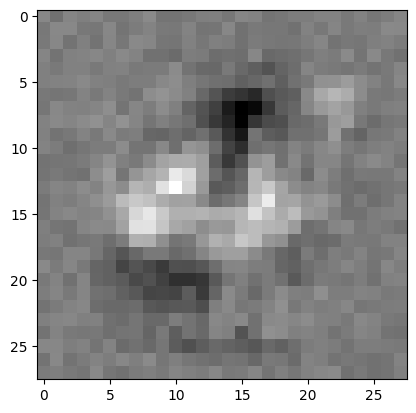

weights: torch.Size([10, 784])
bias:    torch.Size([10])


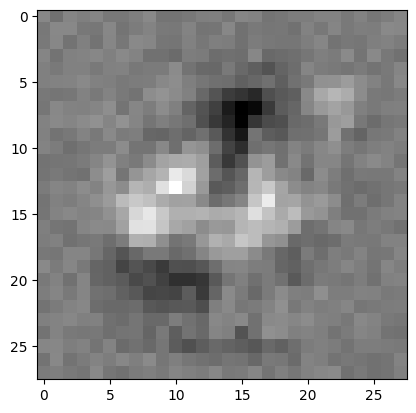

weights: torch.Size([10, 784])
bias:    torch.Size([10])


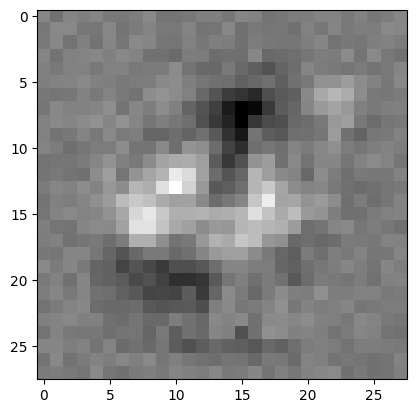

weights: torch.Size([10, 784])
bias:    torch.Size([10])


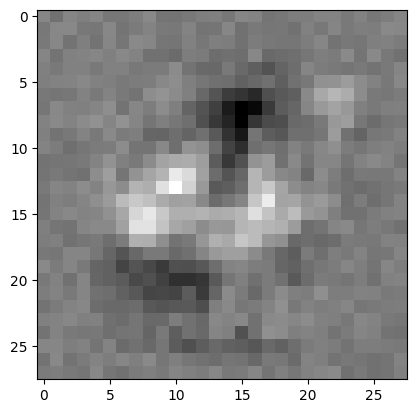

weights: torch.Size([10, 784])
bias:    torch.Size([10])


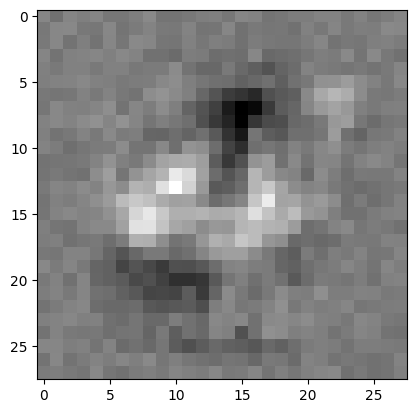

weights: torch.Size([10, 784])
bias:    torch.Size([10])


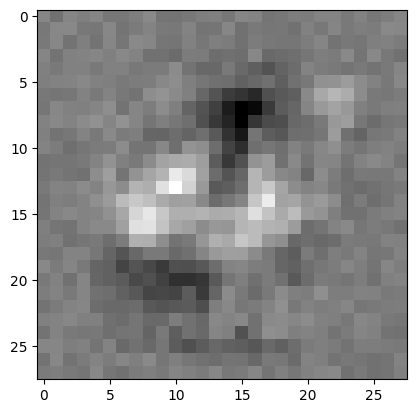

weights: torch.Size([10, 784])
bias:    torch.Size([10])


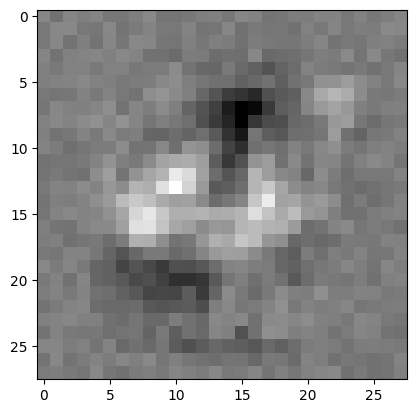

weights: torch.Size([10, 784])
bias:    torch.Size([10])


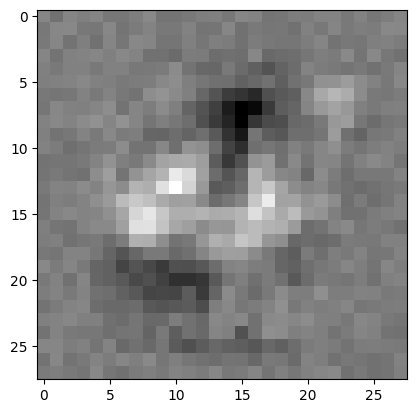

weights: torch.Size([10, 784])
bias:    torch.Size([10])


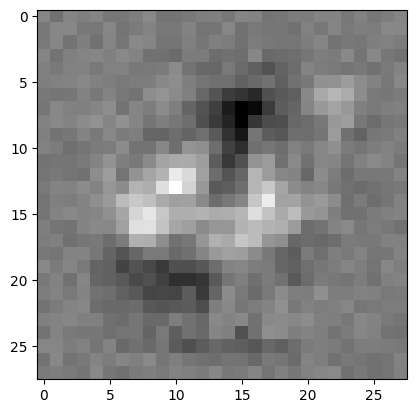

weights: torch.Size([10, 784])
bias:    torch.Size([10])


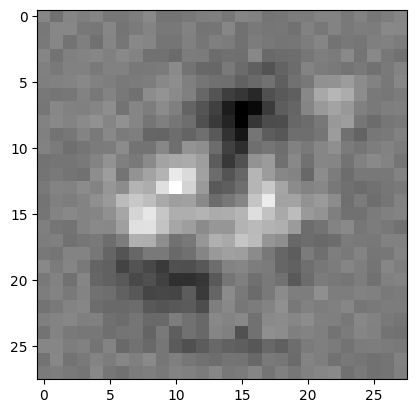

weights: torch.Size([10, 784])
bias:    torch.Size([10])


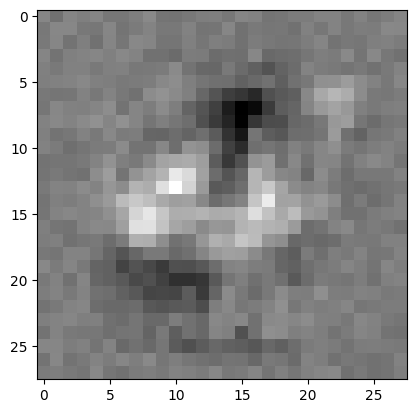

weights: torch.Size([10, 784])
bias:    torch.Size([10])


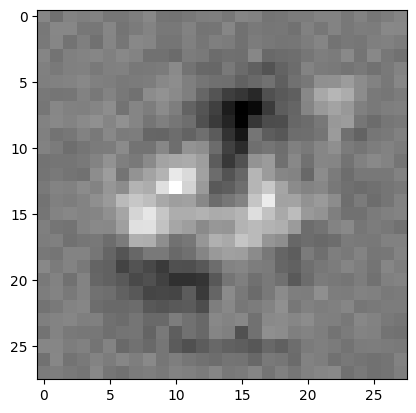

weights: torch.Size([10, 784])
bias:    torch.Size([10])


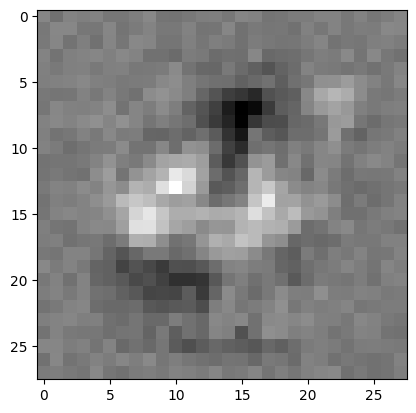

weights: torch.Size([10, 784])
bias:    torch.Size([10])


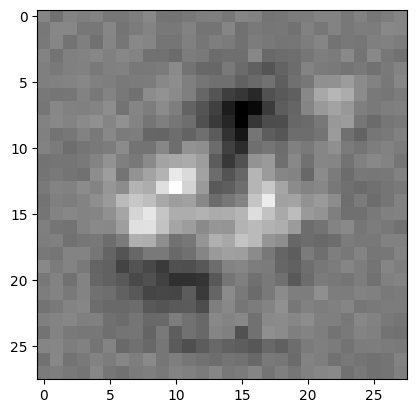

weights: torch.Size([10, 784])
bias:    torch.Size([10])


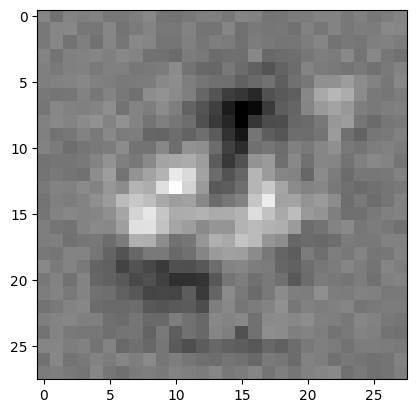

weights: torch.Size([10, 784])
bias:    torch.Size([10])


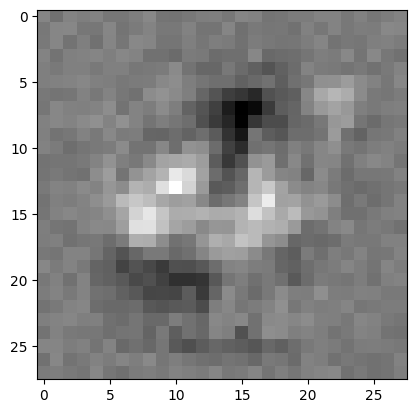

weights: torch.Size([10, 784])
bias:    torch.Size([10])


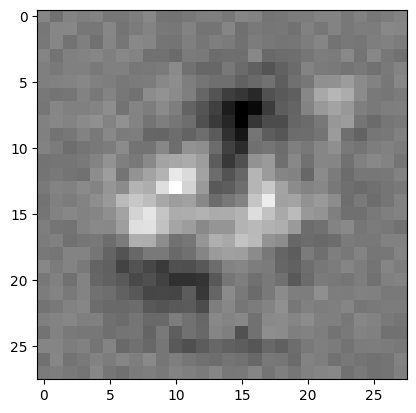

weights: torch.Size([10, 784])
bias:    torch.Size([10])


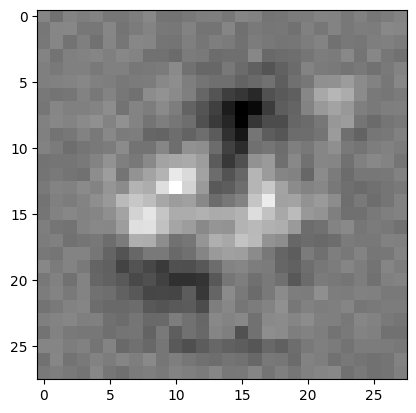

weights: torch.Size([10, 784])
bias:    torch.Size([10])


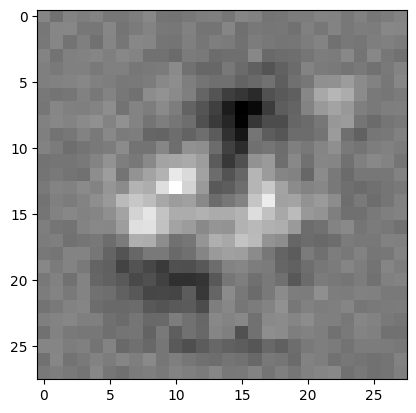

weights: torch.Size([10, 784])
bias:    torch.Size([10])


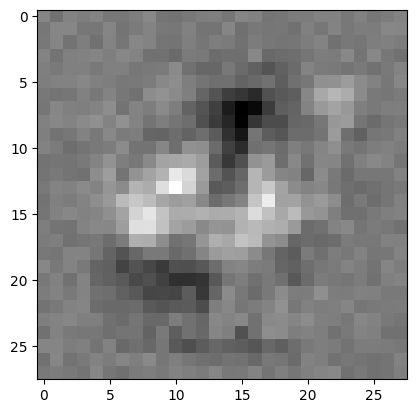

weights: torch.Size([10, 784])
bias:    torch.Size([10])


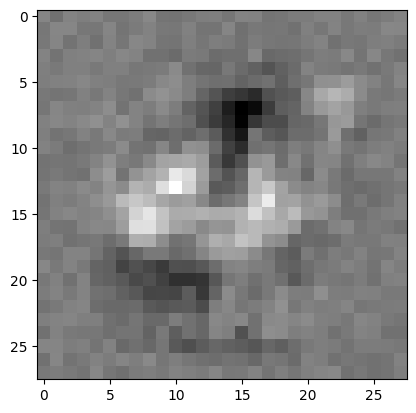

weights: torch.Size([10, 784])
bias:    torch.Size([10])


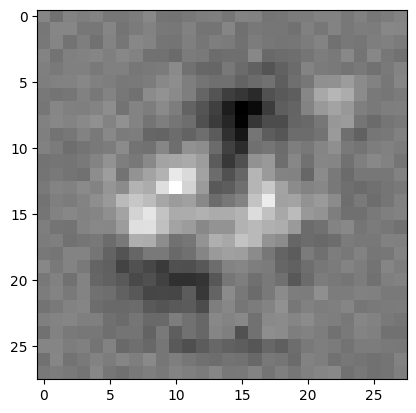

weights: torch.Size([10, 784])
bias:    torch.Size([10])


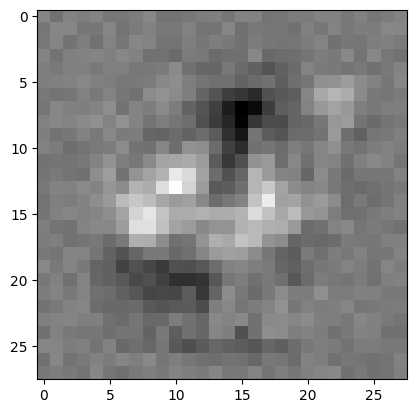

weights: torch.Size([10, 784])
bias:    torch.Size([10])


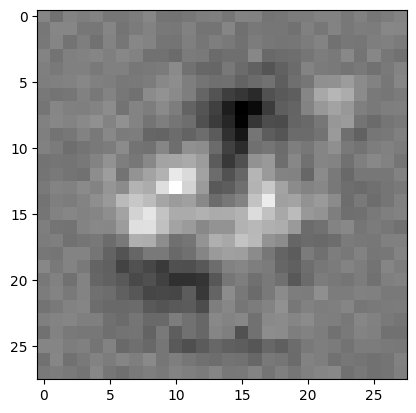

weights: torch.Size([10, 784])
bias:    torch.Size([10])


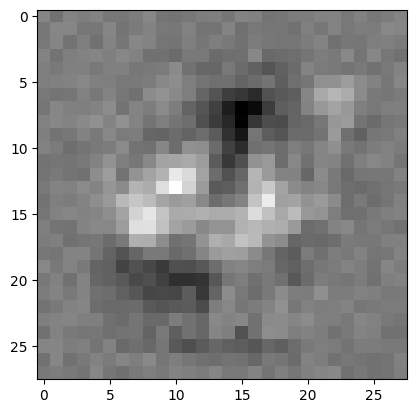

weights: torch.Size([10, 784])
bias:    torch.Size([10])


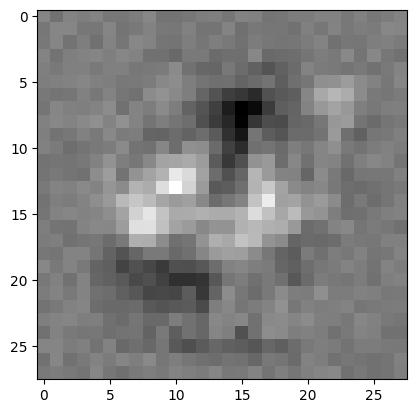

weights: torch.Size([10, 784])
bias:    torch.Size([10])


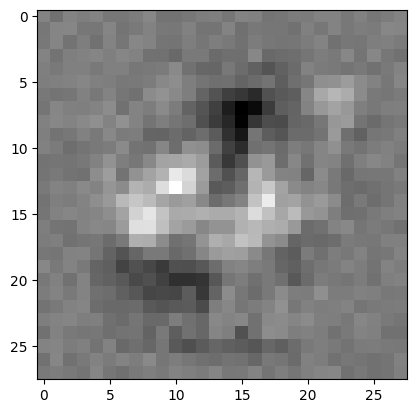

weights: torch.Size([10, 784])
bias:    torch.Size([10])


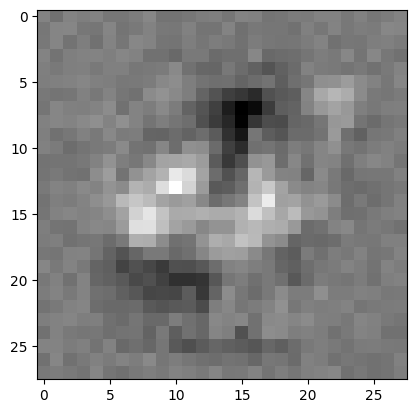

weights: torch.Size([10, 784])
bias:    torch.Size([10])


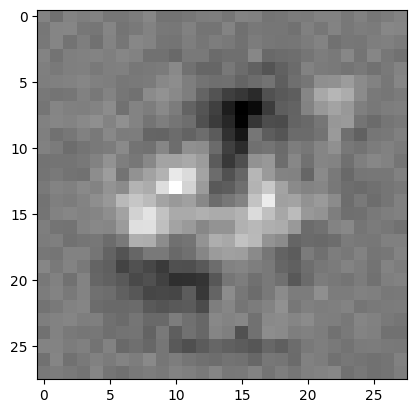

weights: torch.Size([10, 784])
bias:    torch.Size([10])


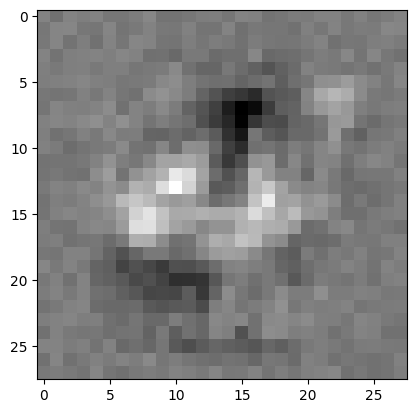

weights: torch.Size([10, 784])
bias:    torch.Size([10])


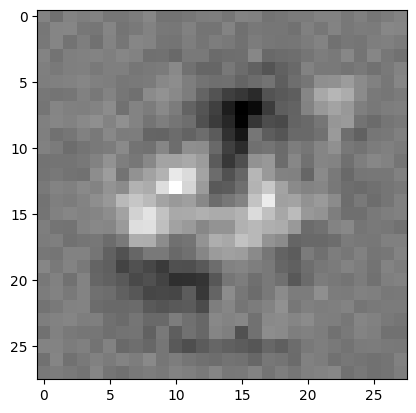

weights: torch.Size([10, 784])
bias:    torch.Size([10])


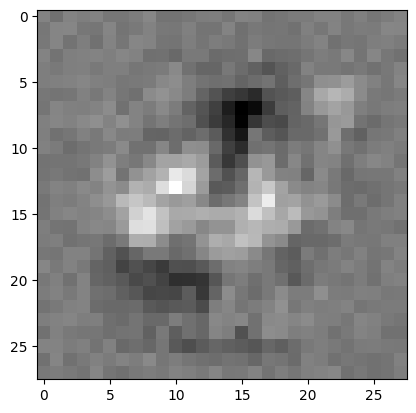

weights: torch.Size([10, 784])
bias:    torch.Size([10])


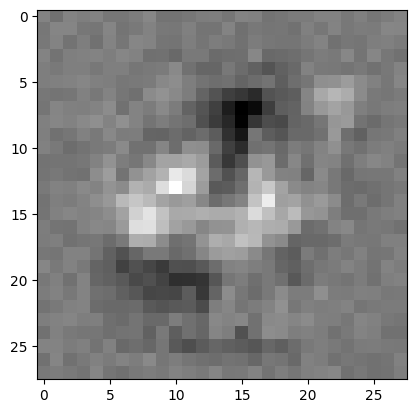

weights: torch.Size([10, 784])
bias:    torch.Size([10])


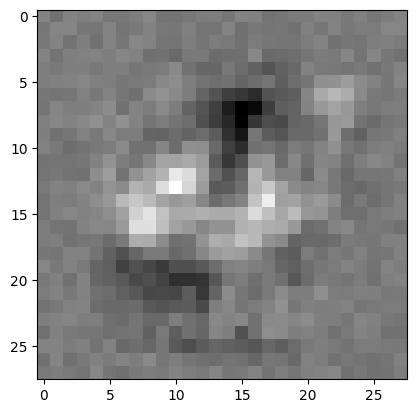

weights: torch.Size([10, 784])
bias:    torch.Size([10])


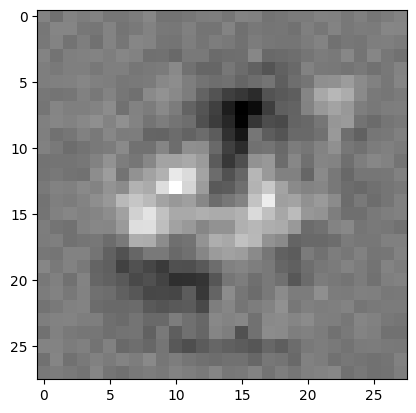

weights: torch.Size([10, 784])
bias:    torch.Size([10])


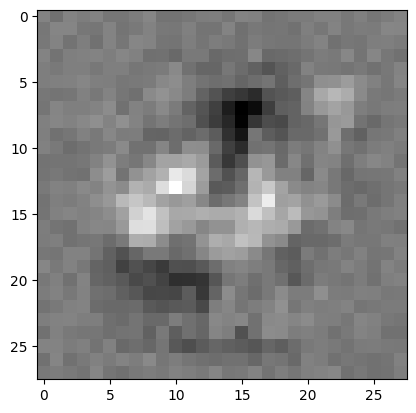

weights: torch.Size([10, 784])
bias:    torch.Size([10])


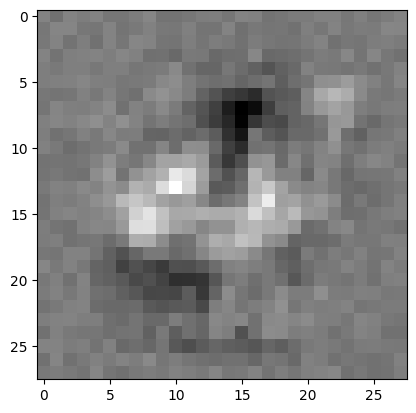

weights: torch.Size([10, 784])
bias:    torch.Size([10])


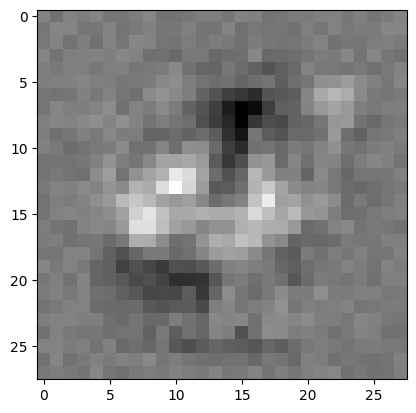

weights: torch.Size([10, 784])
bias:    torch.Size([10])


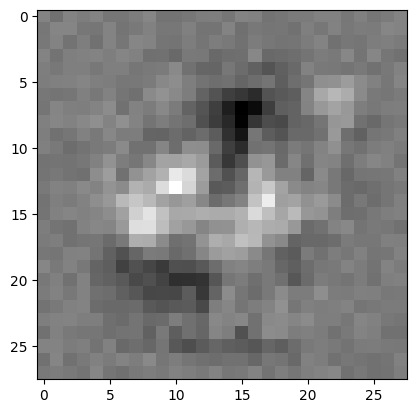

weights: torch.Size([10, 784])
bias:    torch.Size([10])


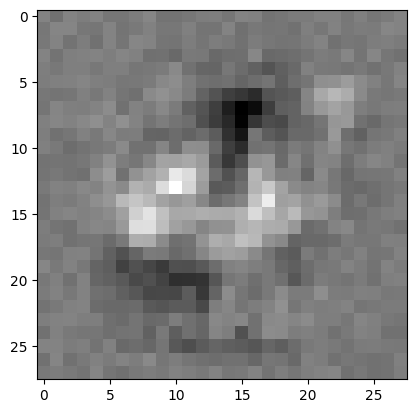

weights: torch.Size([10, 784])
bias:    torch.Size([10])


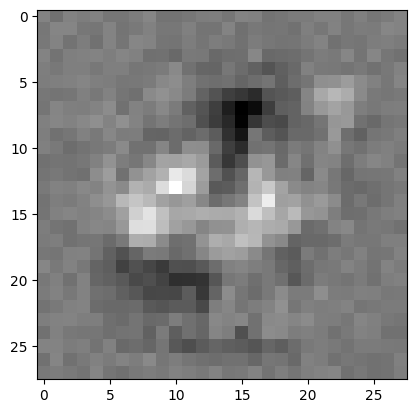

weights: torch.Size([10, 784])
bias:    torch.Size([10])


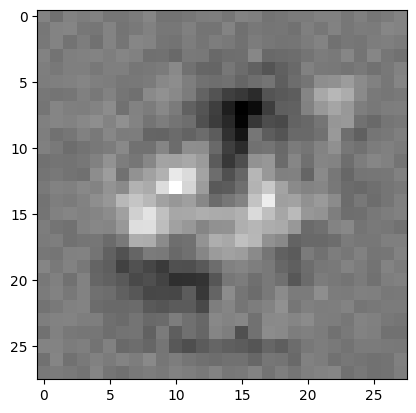

weights: torch.Size([10, 784])
bias:    torch.Size([10])


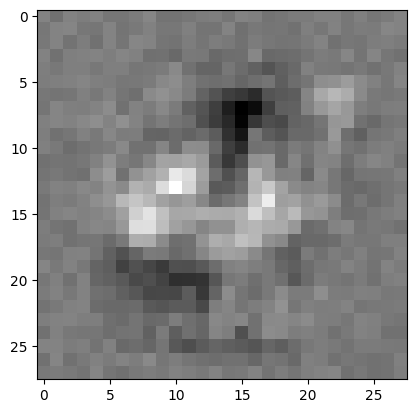

weights: torch.Size([10, 784])
bias:    torch.Size([10])


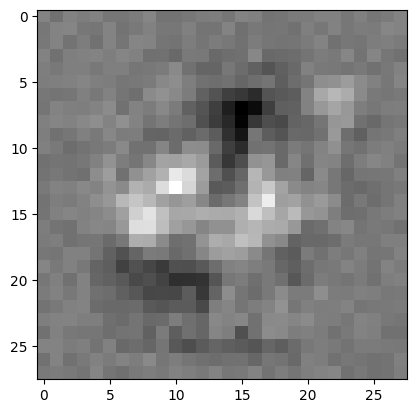

weights: torch.Size([10, 784])
bias:    torch.Size([10])


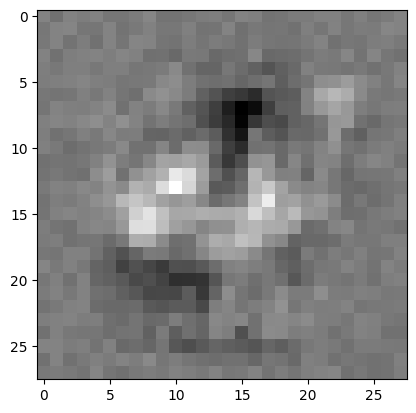

weights: torch.Size([10, 784])
bias:    torch.Size([10])


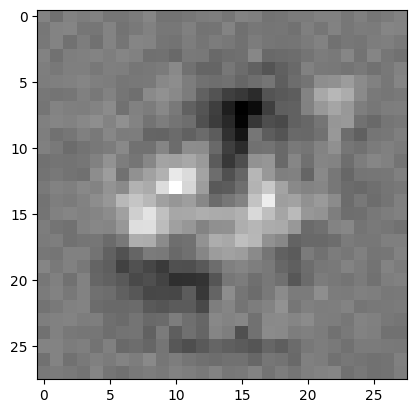

weights: torch.Size([10, 784])
bias:    torch.Size([10])


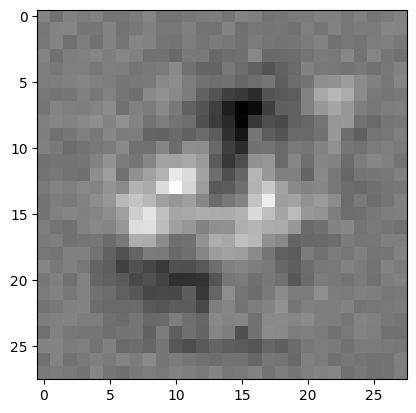

weights: torch.Size([10, 784])
bias:    torch.Size([10])


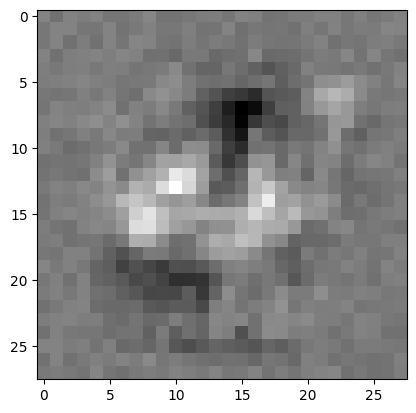

weights: torch.Size([10, 784])
bias:    torch.Size([10])


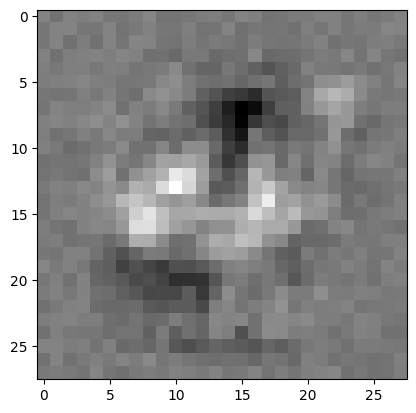

weights: torch.Size([10, 784])
bias:    torch.Size([10])


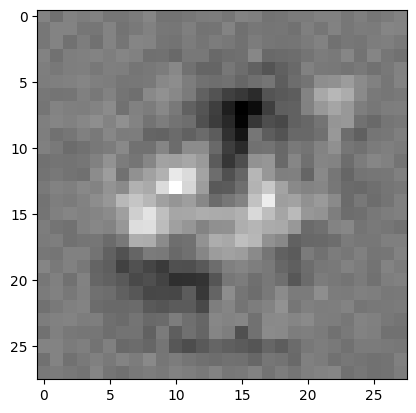

weights: torch.Size([10, 784])
bias:    torch.Size([10])


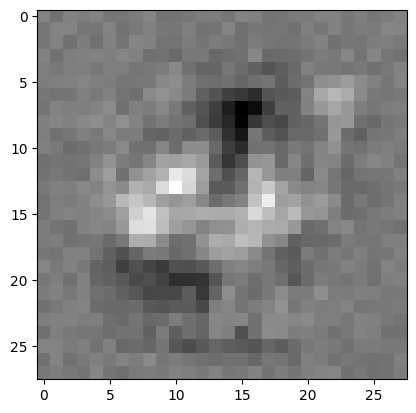

weights: torch.Size([10, 784])
bias:    torch.Size([10])


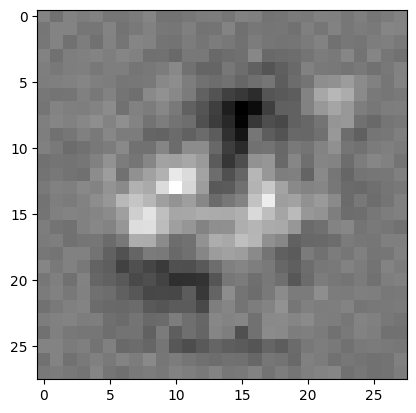

weights: torch.Size([10, 784])
bias:    torch.Size([10])


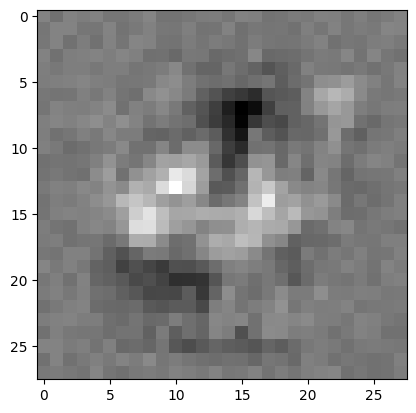

weights: torch.Size([10, 784])
bias:    torch.Size([10])


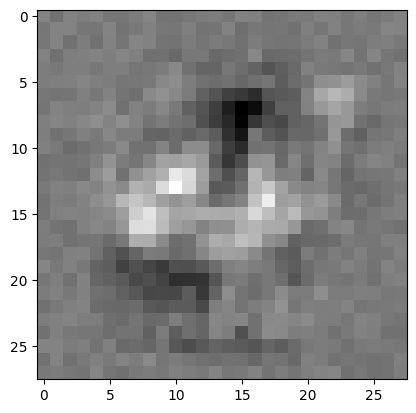

weights: torch.Size([10, 784])
bias:    torch.Size([10])


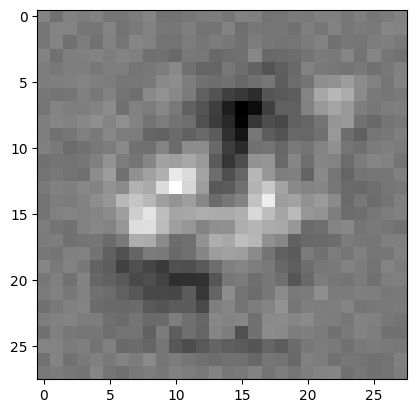

weights: torch.Size([10, 784])
bias:    torch.Size([10])


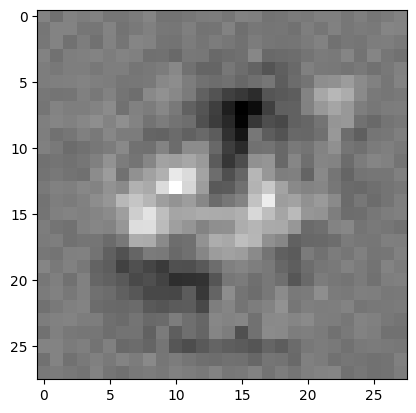

weights: torch.Size([10, 784])
bias:    torch.Size([10])


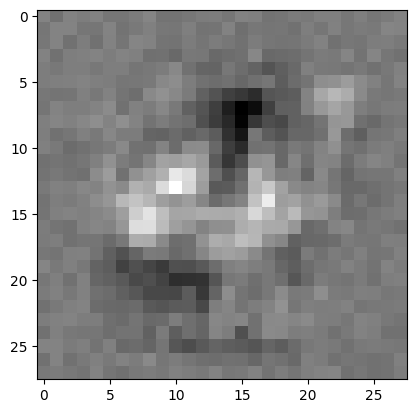

weights: torch.Size([10, 784])
bias:    torch.Size([10])


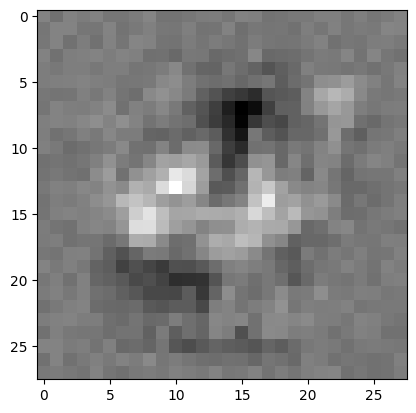

weights: torch.Size([10, 784])
bias:    torch.Size([10])


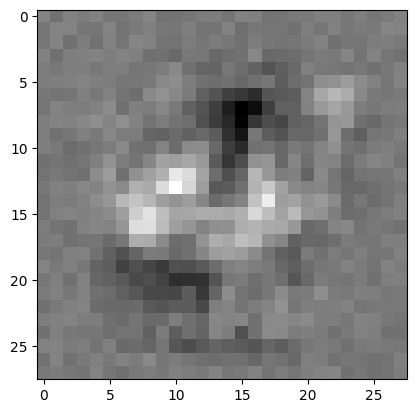

weights: torch.Size([10, 784])
bias:    torch.Size([10])


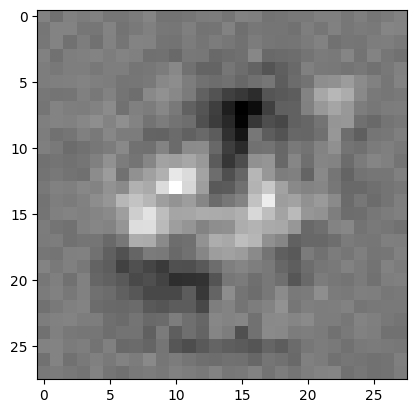

weights: torch.Size([10, 784])
bias:    torch.Size([10])


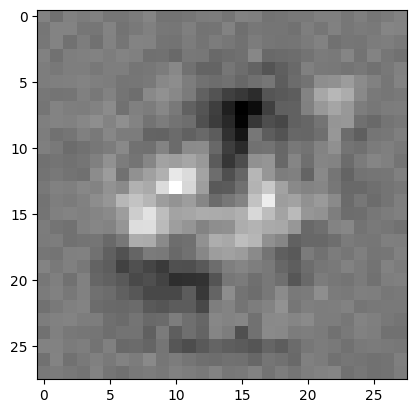

weights: torch.Size([10, 784])
bias:    torch.Size([10])


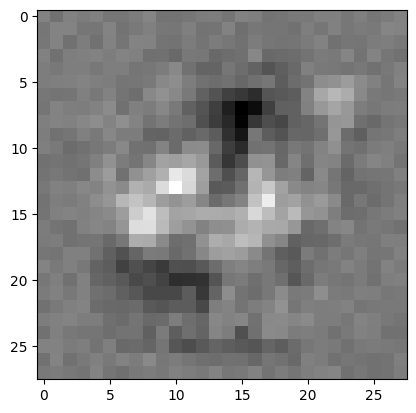

weights: torch.Size([10, 784])
bias:    torch.Size([10])


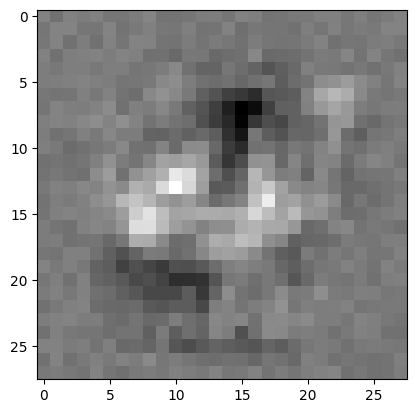

weights: torch.Size([10, 784])
bias:    torch.Size([10])


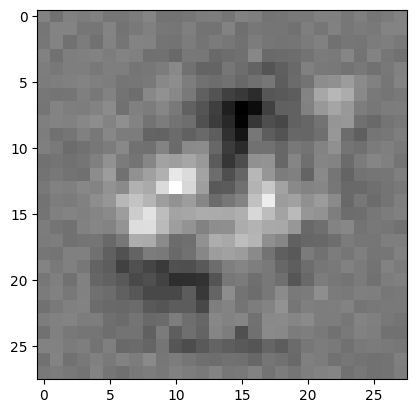

weights: torch.Size([10, 784])
bias:    torch.Size([10])


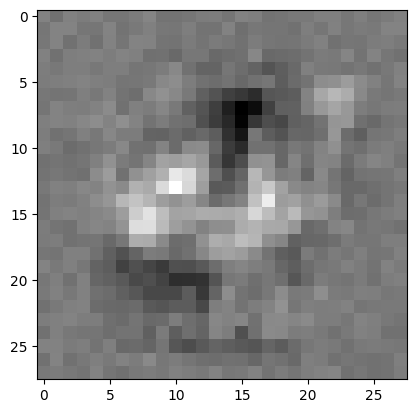

weights: torch.Size([10, 784])
bias:    torch.Size([10])


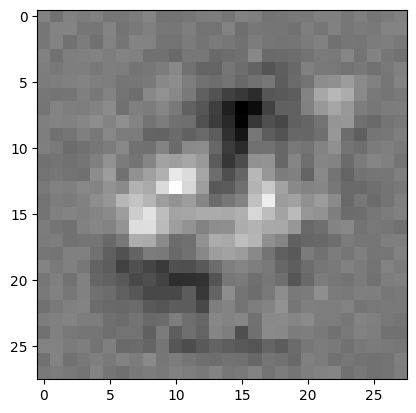

weights: torch.Size([10, 784])
bias:    torch.Size([10])


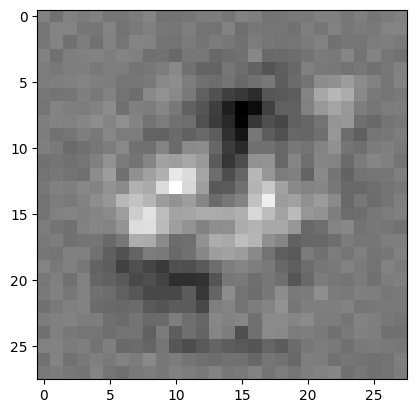

weights: torch.Size([10, 784])
bias:    torch.Size([10])


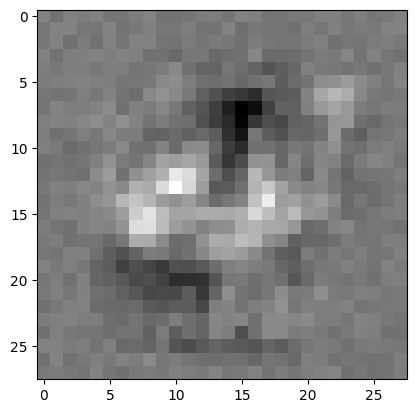

weights: torch.Size([10, 784])
bias:    torch.Size([10])


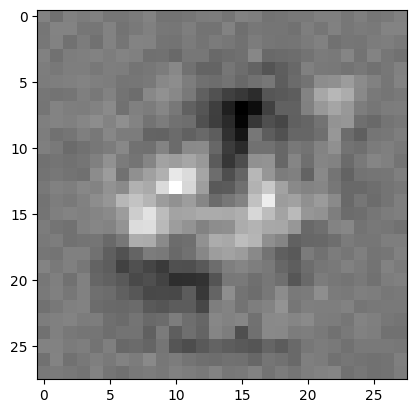

weights: torch.Size([10, 784])
bias:    torch.Size([10])


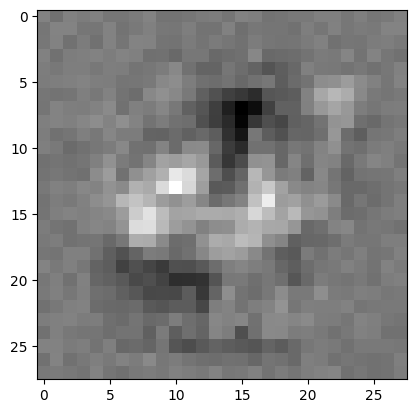

weights: torch.Size([10, 784])
bias:    torch.Size([10])


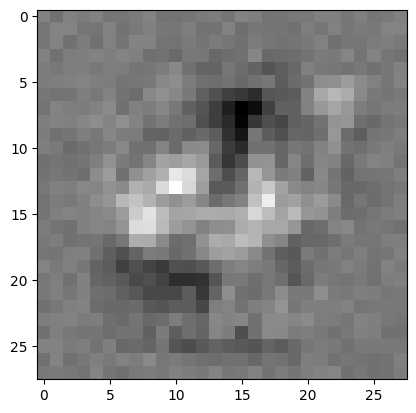

weights: torch.Size([10, 784])
bias:    torch.Size([10])


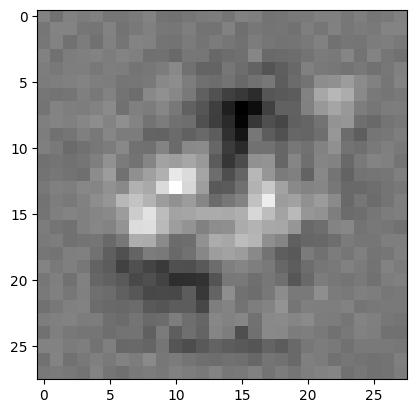

weights: torch.Size([10, 784])
bias:    torch.Size([10])


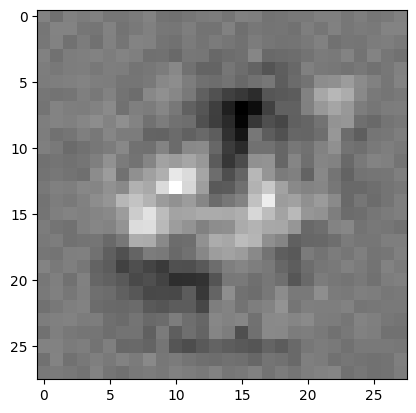

weights: torch.Size([10, 784])
bias:    torch.Size([10])


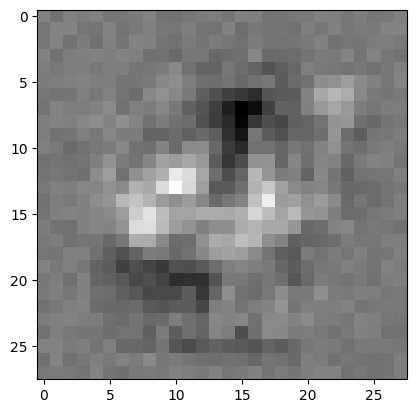

weights: torch.Size([10, 784])
bias:    torch.Size([10])


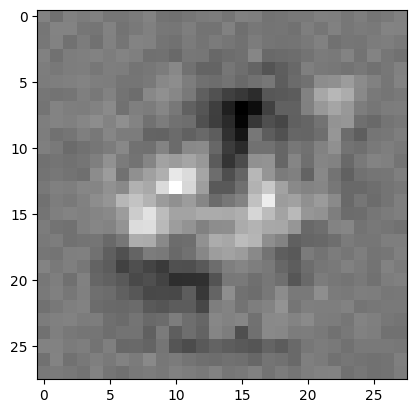

weights: torch.Size([10, 784])
bias:    torch.Size([10])


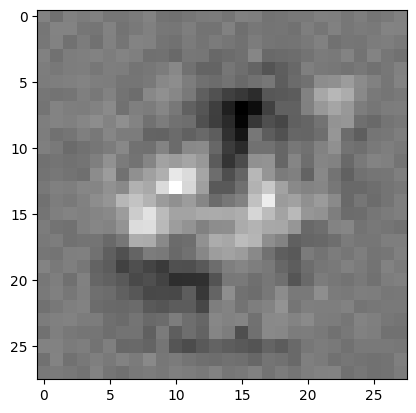

weights: torch.Size([10, 784])
bias:    torch.Size([10])


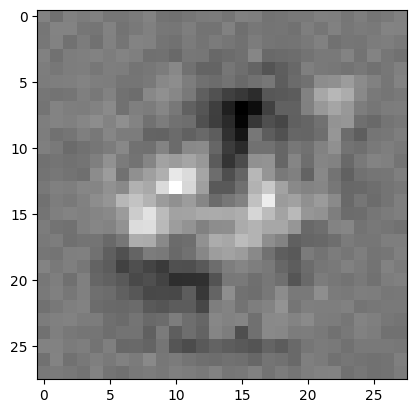

weights: torch.Size([10, 784])
bias:    torch.Size([10])


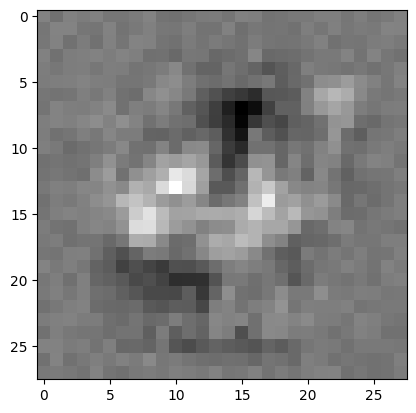

weights: torch.Size([10, 784])
bias:    torch.Size([10])


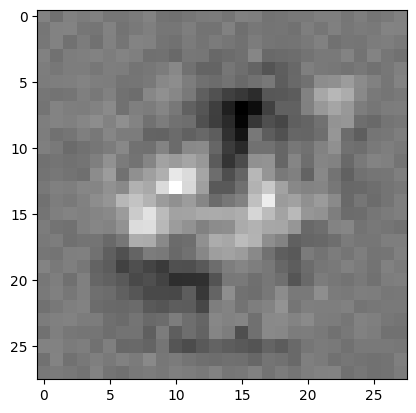

weights: torch.Size([10, 784])
bias:    torch.Size([10])


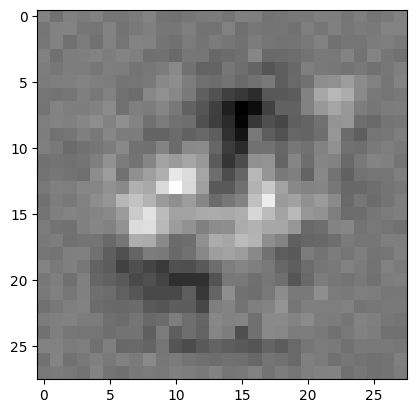

weights: torch.Size([10, 784])
bias:    torch.Size([10])


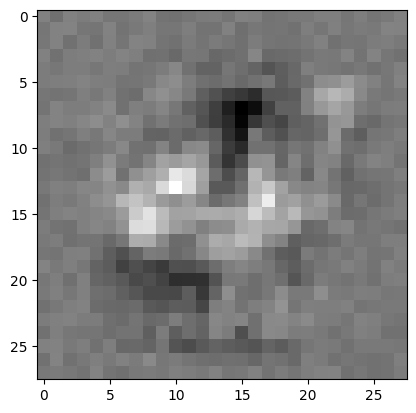

weights: torch.Size([10, 784])
bias:    torch.Size([10])


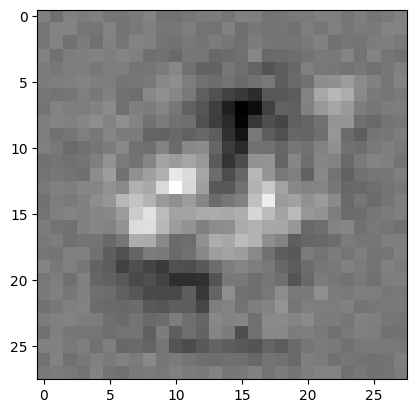

weights: torch.Size([10, 784])
bias:    torch.Size([10])


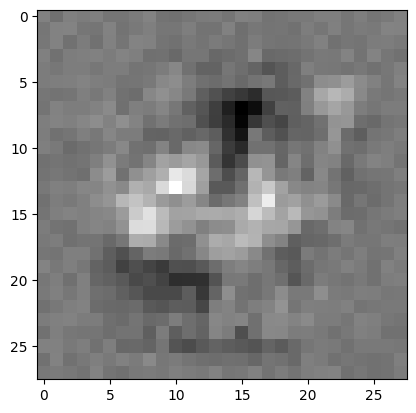

weights: torch.Size([10, 784])
bias:    torch.Size([10])


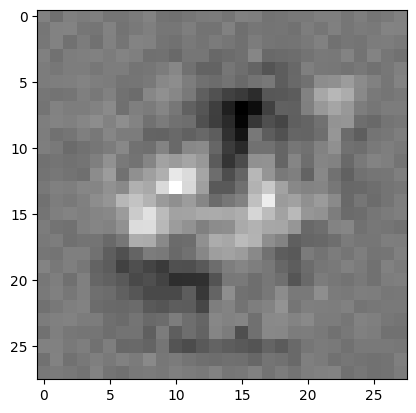

weights: torch.Size([10, 784])
bias:    torch.Size([10])


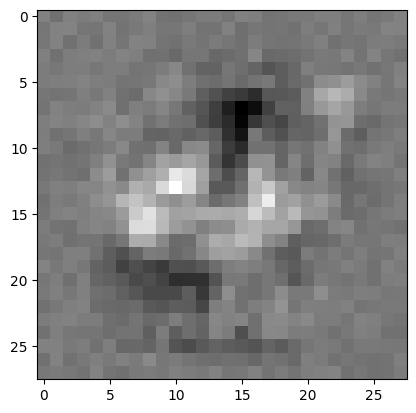

weights: torch.Size([10, 784])
bias:    torch.Size([10])


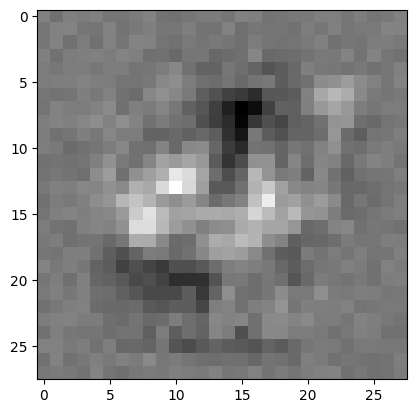

weights: torch.Size([10, 784])
bias:    torch.Size([10])


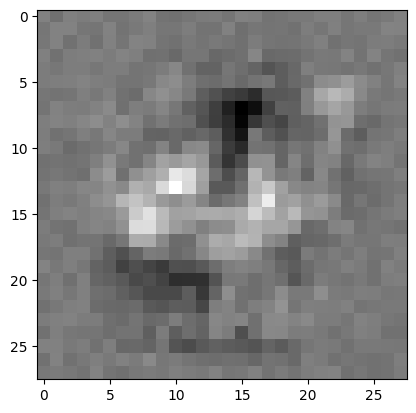

weights: torch.Size([10, 784])
bias:    torch.Size([10])


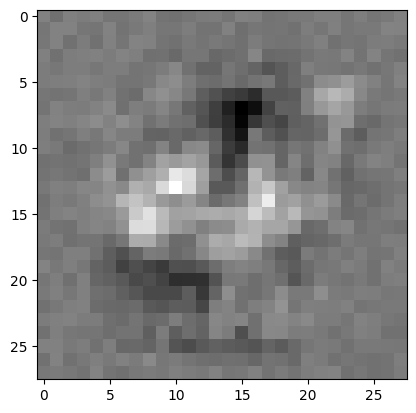

weights: torch.Size([10, 784])
bias:    torch.Size([10])


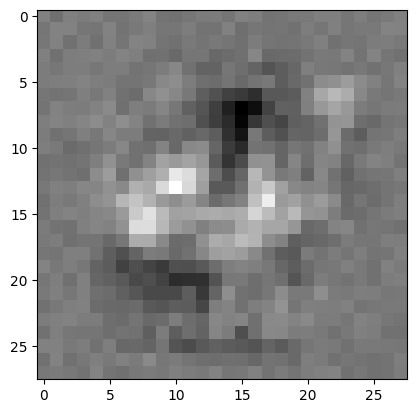

weights: torch.Size([10, 784])
bias:    torch.Size([10])


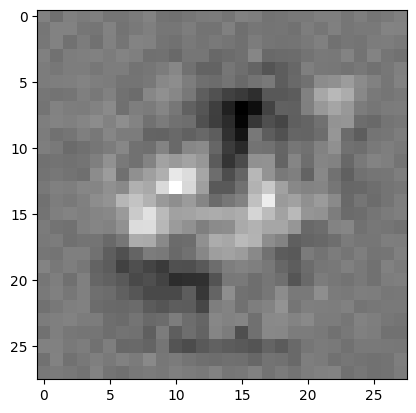

weights: torch.Size([10, 784])
bias:    torch.Size([10])


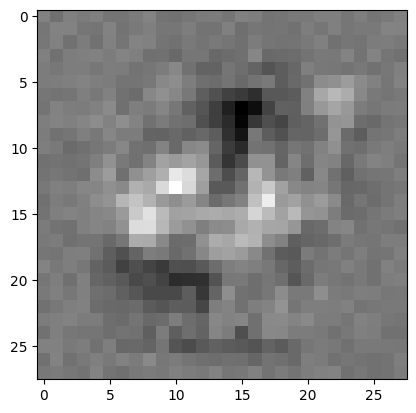

weights: torch.Size([10, 784])
bias:    torch.Size([10])


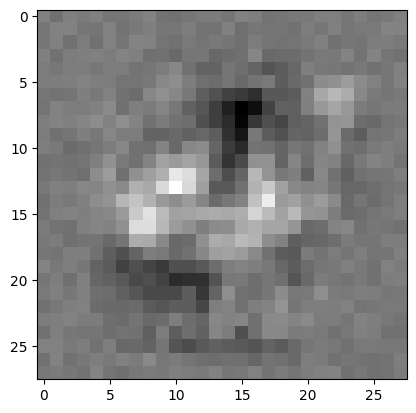

weights: torch.Size([10, 784])
bias:    torch.Size([10])


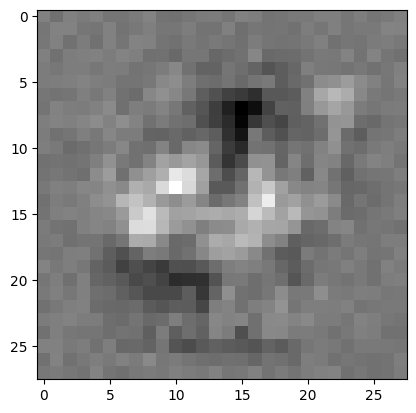

weights: torch.Size([10, 784])
bias:    torch.Size([10])


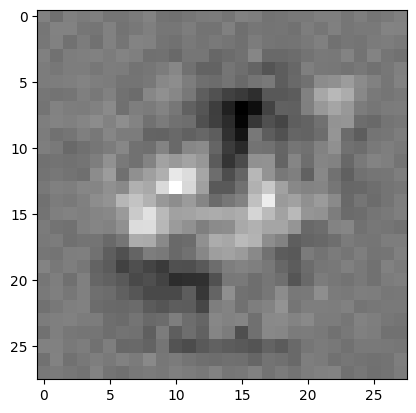

weights: torch.Size([10, 784])
bias:    torch.Size([10])


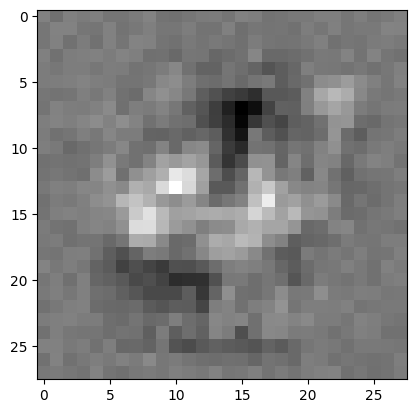

weights: torch.Size([10, 784])
bias:    torch.Size([10])


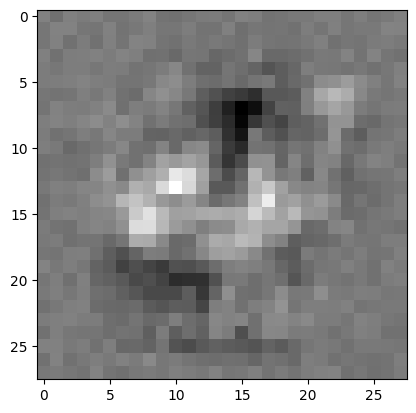

weights: torch.Size([10, 784])
bias:    torch.Size([10])


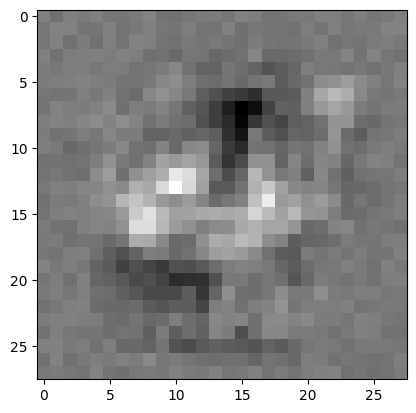

weights: torch.Size([10, 784])
bias:    torch.Size([10])


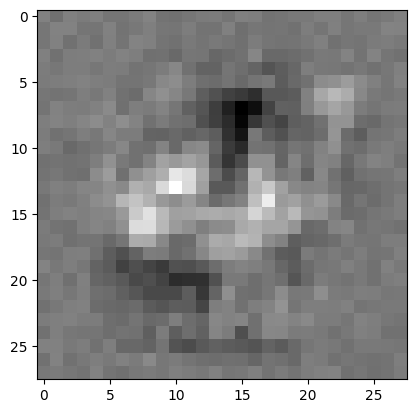

weights: torch.Size([10, 784])
bias:    torch.Size([10])


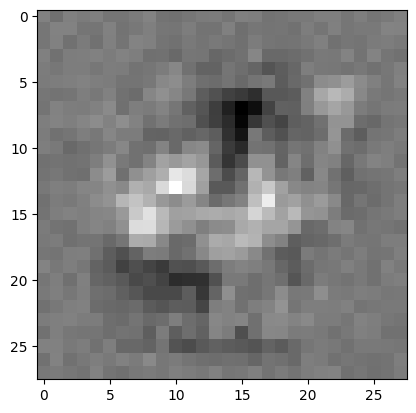

weights: torch.Size([10, 784])
bias:    torch.Size([10])


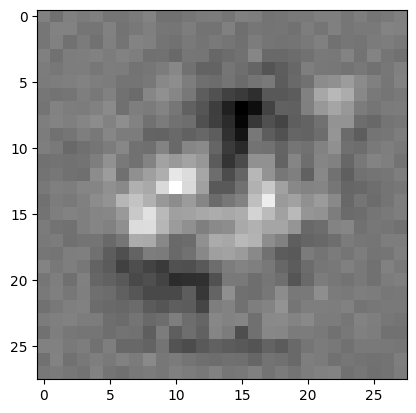

In [ ]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())


    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    #print('Epoch[{}/{}], loss: {:.6f}'
              #.format(i+1, epochs, loss.data, accuracy))

    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 4
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

## Perguntas

1. Qual é o shape da matriz de entrada na rede? (28 * 28)
2. Qual é o shape da saída da rede? (10)
3. Qual é o número total de parâmetros da rede, incluindo o bias? 28 * 28 * 10 + 10

# Aprendizados
